In [2]:
import os
import numpy as np
from PIL import Image
import keras
from tensorflow.keras.layers import Dense, Dropout, Activation
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from sklearn.model_selection import train_test_split

2023-02-26 17:58:46.187956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# encoder inputs
encoder_inputs = keras.Input(shape=12288)

# hidden layers
h = Dense(9000, activation='relu')(encoder_inputs)

# encoder outputs
encoder_outputs = Dense(12288, activation='sigmoid')(h)

# Create the model
autoencoder = keras.Model(inputs=encoder_inputs, outputs=encoder_outputs)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(img_pixel_list, img_pixel_list, epochs=5, batch_size=100)

2023-02-20 15:38:24.026051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 15:38:24.033931: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/5
5/5 [==============================] - 15s 3s/step - loss: 0.0878
Epoch 2/5
5/5 [==============================] - 14s 3s/step - loss: 0.0590
Epoch 3/5
5/5 [==============================] - 13s 3s/step - loss: 0.0506
Epoch 4/5
5/5 [==============================] - 13s 3s/step - loss: 0.0431
Epoch 5/5
5/5 [==============================] - 13s 3s/step - loss: 0.0390


16/16 [==============================] - 6s 361ms/step


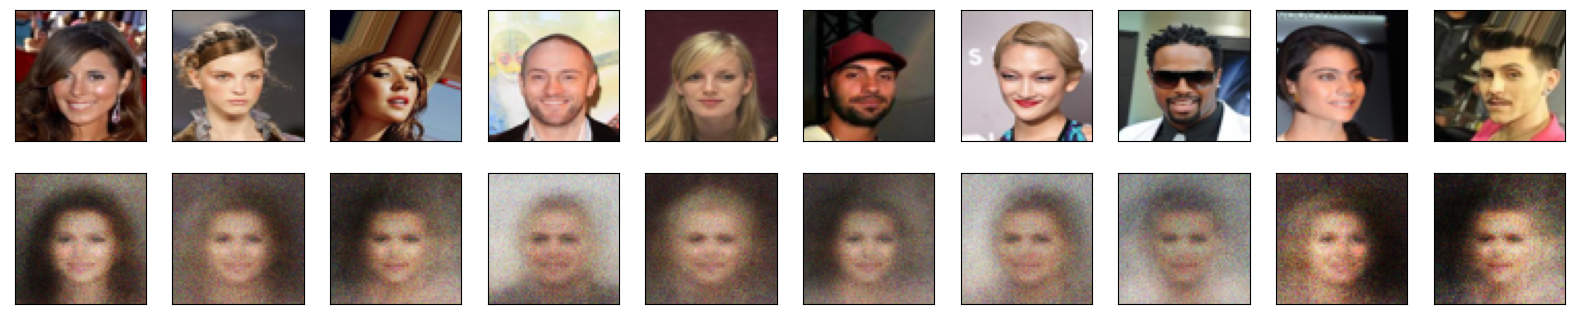

In [5]:
# Self prediction
decoded_imgs = autoencoder.predict(img_pixel_list)
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Afficher les originaux
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(img_pixel_list[i].reshape(64,64,3))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher la reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(64, 64,3))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Test avec code de Sergio

In [34]:
original_dim = img_pixel_list.shape[1]
hidden_encoding_dim = 1536
encoding_dim = 192
hidden_decoding_dim = 1536
dropout_level = 0.1

# "encoded" is the encoded representation of the input
input_img = keras.Input(shape=(original_dim,)) #create an input layer
hidden_encoded = Dense(hidden_encoding_dim, activation='relu')(input_img) #Crée une couche de 512 neurones pour analyser l'image. On lui donne l'input layer
dropout_hidden_encoded = Dropout(dropout_level)(hidden_encoded) #Randomly, on switch off des nodes. Ca évite l'overfit car comme ça, tous les neurones partagent l'info. Ca évite qu'un neurone soit spécialisé
encoded = Dense(encoding_dim, activation='relu')(dropout_hidden_encoded) #Crée encore une couche de neurones
dropout_encoded = Dropout(dropout_level)(encoded) #Re randomly switch off neurones

# "decoded" is the reconstruction of the input
hidden_decoded = Dense(hidden_decoding_dim, activation='relu')(dropout_encoded)
dropout_hidden_decoded = Dropout(dropout_level)(hidden_decoded)
decoded = Dense(original_dim, activation='sigmoid')(dropout_hidden_decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
# This model maps an input to is encoded representation 
encoder = keras.Model(input_img, encoded)
# This model maps an imput with the same dim as the encoded to the reconstruction
input_encoded_img = keras.Input(shape=(encoding_dim,))
hidden_decoder_layer = autoencoder.layers[-3]
hidden_dropout_decoded_layer = autoencoder.layers[-2]
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(input_encoded_img, decoder_layer(hidden_dropout_decoded_layer(hidden_decoder_layer(input_encoded_img))))

## Compiler le modele

In [37]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## Fit le modele

In [38]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
13/13 [==============================] - 8s 550ms/step - loss: 0.6643 - val_loss: 0.6287
Epoch 2/50
13/13 [==============================] - 7s 538ms/step - loss: 0.6244 - val_loss: 0.6146
Epoch 3/50
13/13 [==============================] - 7s 535ms/step - loss: 0.6127 - val_loss: 0.6074
Epoch 4/50
13/13 [==============================] - 7s 535ms/step - loss: 0.6092 - val_loss: 0.5984
Epoch 5/50
13/13 [==============================] - 8s 623ms/step - loss: 0.5980 - val_loss: 0.5907
Epoch 6/50
13/13 [==============================] - 8s 617ms/step - loss: 0.5910 - val_loss: 0.5850
Epoch 7/50
13/13 [==============================] - 8s 623ms/step - loss: 0.5844 - val_loss: 0.5810
Epoch 8/50
13/13 [==============================] - 7s 545ms/step - loss: 0.5802 - val_loss: 0.5765
Epoch 9/50
13/13 [==============================] - 7s 516ms/step - loss: 0.5771 - val_loss: 0.5752
Epoch 10/50
13/13 [==============================] - 7s 515ms/step - loss: 0.5748 - val_loss: 0.5700

## Learning curve

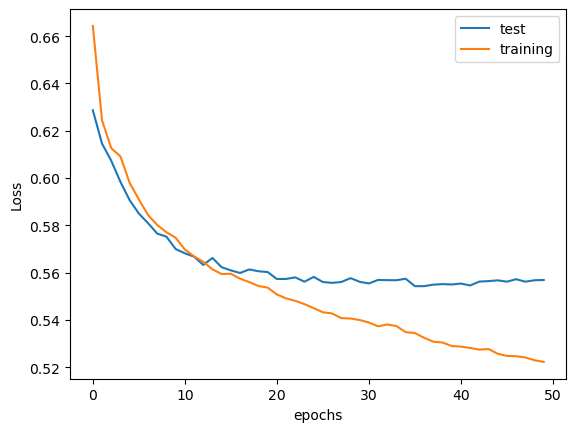

In [39]:
history = autoencoder.history.history

plt.plot(history['val_loss'],label="test")
plt.plot(history['loss'],label="training")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

## Résultats

In [106]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # How many faces we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node 'model_10/dense_12/Relu' defined at (most recent call last):
    File "/home/fannie/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/fannie/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/fannie/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/fannie/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/fannie/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2329/1396803000.py", line 9, in <module>
      encoded_imgs = encoder.predict(X_test)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/fannie/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_10/dense_12/Relu'
In[0] is not a matrix
	 [[{{node model_10/dense_12/Relu}}]] [Op:__inference_predict_function_33921]

# Vrai truc qui marche

In [3]:
def load_dataset(path_to_data) :

    img_list = os.listdir(path_to_data)
    img_pixel_list = []

    for i in range(500):
        img = Image.open(f'{path_to_data}/{img_list[i]}')
        img = img.resize((60, 76))
        img = np.array(img)
        img_pixel_list.append(img)

    img_pixel_list = np.array(img_pixel_list)
    img_pixel_list = img_pixel_list.astype('float32') / 255.0 # il faut normaliser pour + de puissance
    #img_pixel_list = img_pixel_list.reshape((len(img_pixel_list), np.prod(img_pixel_list.shape[1:])))  # on met ça en vecteur 1D en ligne, mais pas besoin avec conv2D
    
    return img_pixel_list

In [4]:
def encodeur_decodeur():
    """
    
    Renvoie l'auto encodeur, l'encodeur et le décodeur compilés
    
    
    """

    input_shape = (76, 60, 3) #taille des input
    encoding_dim = (19, 15, 32) #dimesion de l'objet encodé
    dropout_level = 0.1 #Dropout level

    
    # Define encoder layers
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    #x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    #x = MaxPooling2D((2, 2), padding='same')(x)
    
    

    # Define decoder layers
    #x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    #x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    
    input_encoded_img = keras.Input(shape=(encoding_dim))
    
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    decoder = keras.Model(input_encoded_img, autoencoder.layers[-1](autoencoder.layers[-2](autoencoder.layers[-3](autoencoder.layers[-4](autoencoder.layers[-5](input_encoded_img))))))
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    
    return autoencoder,encoder,decoder

In [5]:
def plot_loss(autoencoder):
    """
    Plot la loss de l'auto encodeur : si on a un bon modèele, val loss est proche de loss, et on veut une loss faible
    """

    history = autoencoder.history.history

    plt.plot(history['val_loss'],label="test")
    plt.plot(history['loss'],label="training")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()

In [6]:
def plot_image_reconstruction(autoencoder,X_test,n=10):

    """n : combien de faces on display
    X_test : l'array des images tests"""
    
    decoded_imgs = autoencoder.predict(X_test)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(76, 60,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(76, 60,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Tests des fonctions

In [7]:
img_pixel_list = load_dataset('/home/fannie/Documents/S2/Logiciel/Projet_logiciel/CelebA/Img/img_align_celeba')

In [8]:
X_train, X_test = train_test_split(img_pixel_list,
                                   test_size=0.2, 
                                   random_state=0)

In [9]:
autoencoder,encoder,decoder = encodeur_decodeur()
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 76, 60, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 76, 60, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 30, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 15, 32)        9248  

2023-02-26 17:58:55.554755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 17:58:55.555949: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


                                                                 
 conv2d_2 (Conv2D)           (None, 19, 15, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 38, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 30, 32)        9248      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 76, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 76, 60, 3)         867       
                                                                 
Total params: 19,363
Trainable params: 19,363
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
4/4 [==============================] - 4s 1s/step - loss: 0.6755 - val_loss: 0.6509
Epoch 2/10
4/4 [==============================] - 4s 1s/step - loss: 0.6311 - val_loss: 0.6002
Epoch 3/10
4/4 [==============================] - 4s 944ms/step - loss: 0.5830 - val_loss: 0.5681
Epoch 4/10
4/4 [==============================] - 4s 908ms/step - loss: 0.5603 - val_loss: 0.5496
Epoch 5/10
4/4 [==============================] - 4s 972ms/step - loss: 0.5476 - val_loss: 0.5398
Epoch 6/10
4/4 [==============================] - 4s 978ms/step - loss: 0.5382 - val_loss: 0.5317
Epoch 7/10
4/4 [==============================] - 4s 982ms/step - loss: 0.5289 - val_loss: 0.5278
Epoch 8/10
4/4 [==============================] - 4s 999ms/step - loss: 0.5232 - val_loss: 0.5204
Epoch 9/10
4/4 [==============================] - 4s 1s/step - loss: 0.5176 - val_loss: 0.5185
Epoch 10/10
4/4 [==============================] - 4s 1s/step - loss: 0.5149 - val_loss: 0.5145


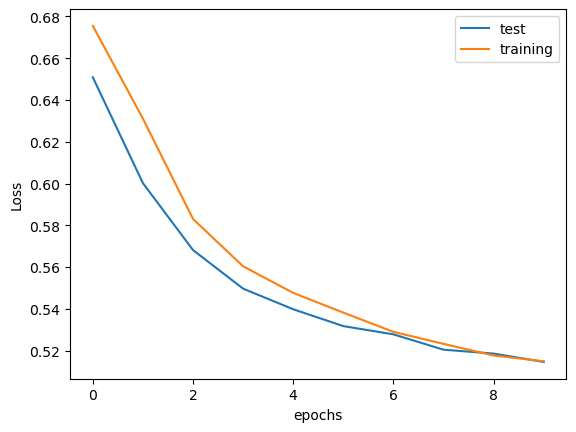

In [11]:
plot_loss(autoencoder)

4/4 [==============================] - 0s 81ms/step


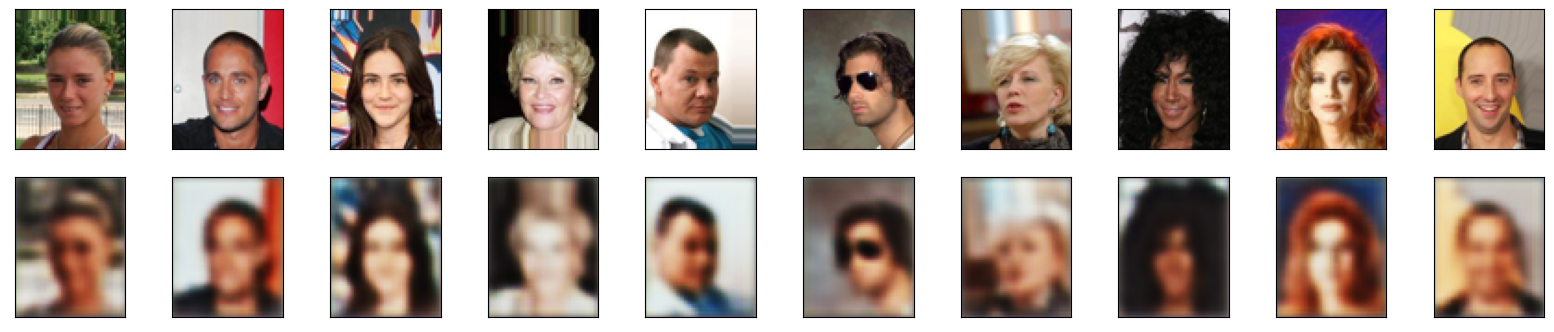

In [12]:
plot_image_reconstruction(autoencoder,X_test) #plot le résultat de l'encodeur pas séparé

## Test du bruit sur X_test

In [36]:
X_test_encoded = encoder.predict(X_test) #images encodées

4/4 [==============================] - 0s 40ms/step


In [40]:
for i in range (10) :

    a,b,c = X_test_encoded[i].shape
    X_test_encoded[i] = X_test_encoded[i] + 2*np.random.rand(a,b,c) #on ajute du bruit sur l'encodage

In [41]:
X_test_decoded_noisy = decoder.predict(X_test_encoded)

4/4 [==============================] - 0s 63ms/step


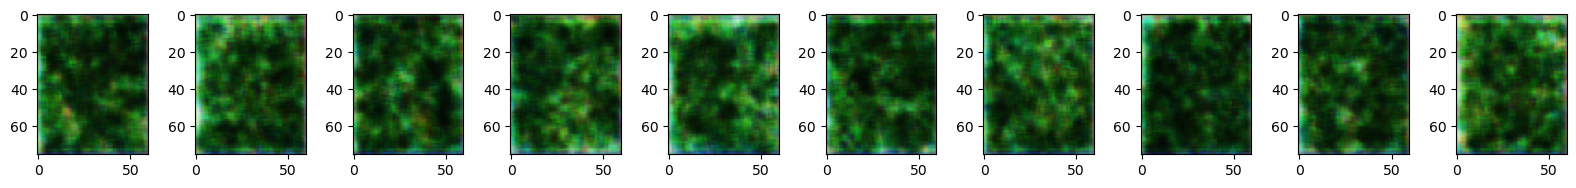

In [42]:
plt.figure(figsize=(20, 4))
for i in range (10) :
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test_decoded_noisy[i].reshape(76, 60,3))